## Juntar y limpiar archivos

En este notebook vamos a limpiar y a generar groupbys en los archivos históricos para poder alimentar a los modelos de ML adecuadamente.

- __Datos recibidos:__ obtenidos de [el portal de calidad del aire de la CDMX](http://www.aire.cdmx.gob.mx/default.php?opc='aKBhnmI='&opcion=Zg==)
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com

__Notas del proyecto__
Necesitamos generar un csv con los niveles máximos, mínimo y promedio por día, se perderá la información de la estación, también generaremos el atributo PM10mean y PM25mean que representarán los valores de las últimas 24 horas de los contaminantes.

calidad de caire
pronostico contaminación

## Pasos
[X] Leer los 10 archivos de contaminación <br>
[X] concatenar los archivos<br>
[X] Hacer el mes y el día columnas<br><br>
[X] Hacer el rollinng para PM10 y PM25<br><br>

juntar<br>
[X] juntar archivos de append y rolling <br><br>


In [22]:
import numpy as np


import pandas as pd

import datetime

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

## Leamos los DF generados

Leemos los archivos por hora:

Declaramos todos los archivos enuna sola lista

In [23]:
lista = ["cont_hora2000.csv" ,"cont_hora2004.csv","cont_hora2008.csv", "cont_hora2012.csv",
         "cont_hora2016.csv","cont_hora2001.csv" , "cont_hora2005.csv","cont_hora2009.csv",
         "cont_hora2013.csv", "cont_hora2017.csv","cont_hora2002.csv","cont_hora2006.csv", 
         "cont_hora2010.csv", "cont_hora2014.csv", "cont_hora2018.csv","cont_hora2003.csv",
         "cont_hora2007.csv", "cont_hora2011.csv","cont_hora2015.csv","cont_hora2019.csv"]

Leemos los archivos y creamos un diccionario:

In [24]:
data_hora = {}
for elem in lista:
    data_hora[elem[9:13]] = pd.read_csv(str('/home/paw/DanielBustillos/contaminación/datasets/por_hora/'+elem))
    data_hora[elem[9:13]] = data_hora[elem[9:13]].iloc[:,1:]

Apendeamos todos los DF

In [25]:
df_append = pd.DataFrame(columns=data_hora["2019"].columns.tolist())
for key in data_hora:
    df_append = df_append.append(data_hora[key], ignore_index=True,sort=True)

Nos quedamos únicamente con los datos del 2010 en adelante:

In [26]:
df_append = df_append[df_append.fecha > "2016-01-01 23:00:00"]

Arreglamos las fechas, vamos a generar columnas con el atributo hora,dia,mes. Además, vamos a hacer que la columna fecha contenga la hora:

In [27]:
df_append['dia'] = df_append['fecha'].astype(str).str[8:10]
df_append['mes'] =  df_append['fecha'].astype(str).str[5:7]
df_append['fecha'] = df_append['fecha'].astype(str).str[0:10]

In [28]:
df_append['fecha']  = pd.to_datetime([''.join([' '.join([df_append.loc[i, 'fecha'], 
                                                         str(df_append.loc[i, 'hora'])]),':00']) for i in df_append.index])
df_append['fecha'] = pd.to_datetime(df_append['fecha'], format='%Y-%m-%d %H:%M:%S')

Ordenemos el DF por fecha y estación:

In [29]:
df_append = df_append.sort_values(['id_station','fecha'], ascending=[1, 1])

In [30]:
#df_append = df_append.drop_duplicates()
#df_append = df_append[1::]
df_append = df_append.drop(["PBa","PMCO","UVA","UVB"],axis=1)

Vamos a quedarnos con las celdas donde Pm10 y Pm2.5 son no nulas.

In [31]:
#df_append = df_append.dropna() ##porque????
df_append = df_append.dropna(subset=['PM10',"PM2.5"]).reset_index()

Grafiquemos PM10 y PM25:

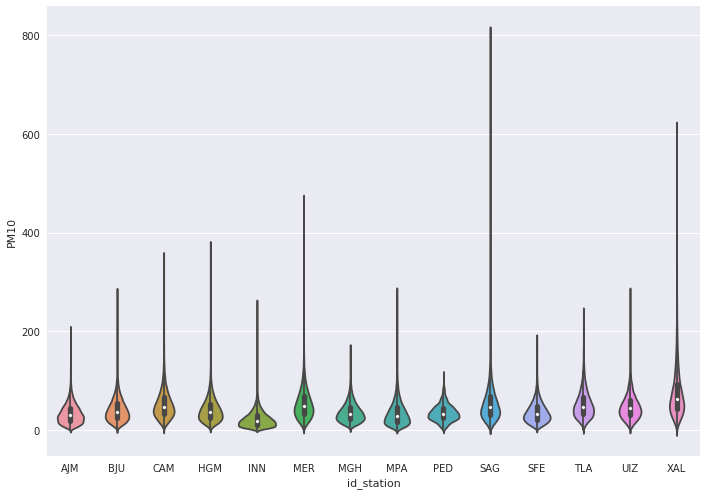

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.violinplot(x="id_station", y="PM10", data=df_append)

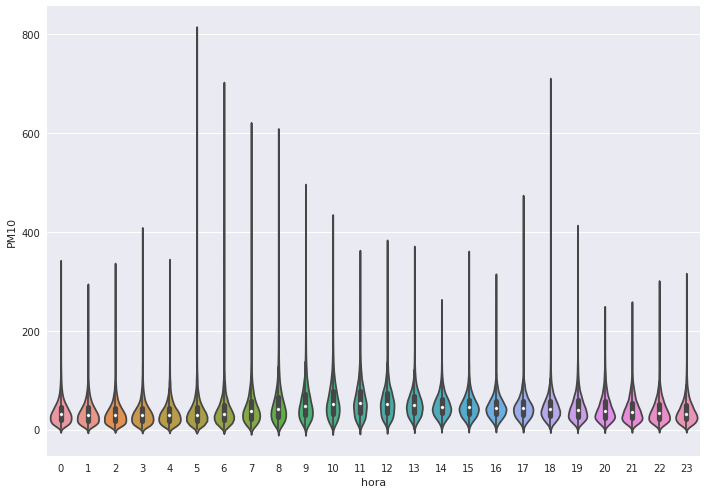

In [33]:
ax = sns.violinplot(x="hora", y="PM10", data=df_append)

Vemos que tenemos valores muy grandes, Jiang (2004) reportó que para valores mayores de 300 puntos, las mediciones no son confiables, vamos a quedarnos con mediciones menores a esta cota:

__Jiang, D., Zhang, Y., Hu, X., Zeng, Y., Tan, J., & Shao, D. (2004). Progress in developing an ANN model for air pollution index forecast. Atmospheric Environment, 38(40 SPEC.ISS.), 7055–7064. https://doi.org/10.1016/j.atmosenv.2003.10.066__

No queremos perder fechas, vamos a quedarnos con el valor anterior al outlier:

In [34]:
for i in range(len(df_append)):
    if df_append.loc[i,"PM10"] > 210:
        df_append.loc[i,"PM10"] = df_append.loc[i-1,"PM10"]
    if df_append.loc[i,"PM2.5"] > 210:
        df_append.loc[i,"PM2.5"] = df_append.loc[i-1,"PM2.5"]

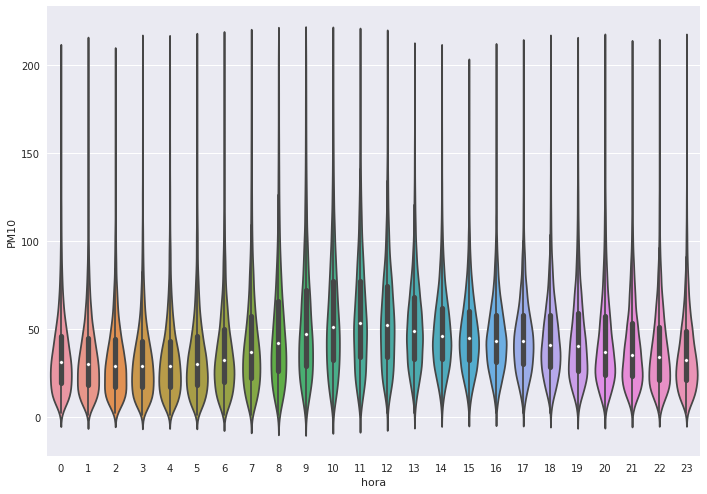

In [35]:
ax = sns.violinplot(x="hora", y="PM10", data=df_append)


# Datos por día: mean(), max(), min()

### Creamos un Df con los datos promedio por hora oara rellenar los nan del DF original

In [36]:
df_append.head(10)

,index,CO,NO,NO2,NOX,O3,PM10,PM2.5,RH,SO2,TMP,WDR,WSP,dia,fecha,hora,id_station,mes
0,720730,0.6,3,20.0,24.0,11.0,32.0,19,71.0,8.0,12.6,230.0,2.0,03,2016-01-03 00:00:00,0,AJM,01
1,720222,0.5,1,17.0,18.0,21.0,26.0,14,63.0,2.0,14.6,166.0,2.3,03,2016-01-03 01:00:00,1,AJM,01
2,720245,0.5,1,19.0,20.0,17.0,26.0,13,67.0,3.0,13.9,222.0,1.1,03,2016-01-03 02:00:00,2,AJM,01
3,720268,0.6,1,27.0,28.0,11.0,34.0,16,71.0,7.0,13.6,223.0,1.2,03,2016-01-03 03:00:00,3,AJM,01
4,720290,0.6,1,25.0,26.0,12.0,39.0,23,72.0,9.0,13.4,212.0,2.0,03,2016-01-03 04:00:00,4,AJM,01
5,720312,0.6,1,25.0,26.0,11.0,38.0,23,72.0,8.0,13.1,177.0,1.9,03,2016-01-03 05:00:00,5,AJM,01
6,720334,0.5,1,20.0,21.0,13.0,31.0,19,73.0,6.0,12.7,190.0,1.7,03,2016-01-03 06:00:00,6,AJM,01
7,720356,0.5,1,20.0,22.0,12.0,32.0,19,74.0,6.0,12.6,180.0,1.5,03,2016-01-03 07:00:00,7,AJM,01
8,720378,0.7,12,24.0,35.0,9.0,32.0,19,76.0,6.0,12.2,220.0,2.5,03,2016-01-03 08:00:00,8,AJM,01
9,720400,0.9,25,25.0,50.0,11.0,44.0,25,77.0,12.0,12.4,23.0,1.6,03,2016-01-03 09:00:00,9,AJM,01


In [37]:
data_24 = df_append.set_index('fecha')

ahora vamos a sacar el promedio de las ultimas 24 horas por estación para el PM10 y el PM25:

In [38]:
data_24 = data_24.groupby('id_station')[["PM10","PM2.5"]].rolling(24).mean().dropna().reset_index()

In [39]:
data_24 = data_24.rename(columns={'PM10': 'PM10mean',"PM2.5":'PM25mean'})

## unir los archivos:

Unimos los dos DF:

In [40]:
data_day = pd.merge(df_append, data_24, on=["fecha","id_station"])

Veamos PM10mean y PM25mean

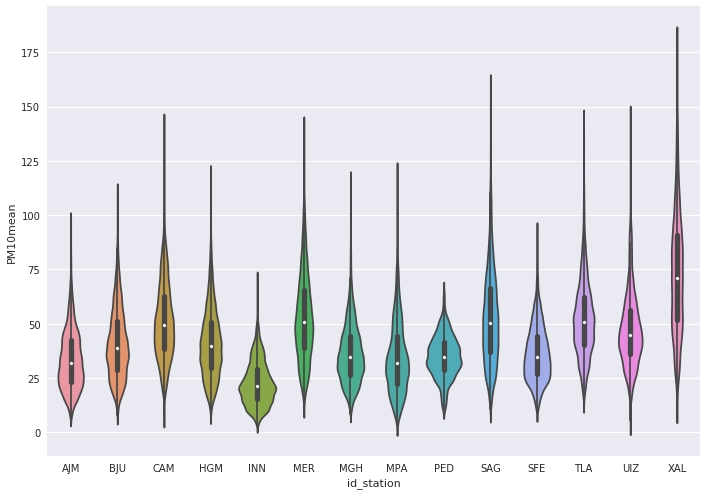

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.violinplot(x="id_station", y="PM10mean", data=data_day)

Vamos a eliminar las estaciones PED y PLA, aparentemente tienen muchos outliers:

In [42]:
data_day.to_csv("./datos_entrenamiento_10-19.csv",index=False)